In [1]:
print("cnn")

cnn


In [2]:
import gensim.models.keyedvectors as word2vec
model_embedding = word2vec.KeyedVectors.load('./word.model')

word_labels = []
max_seq = 70
embedding_size = 128

for word in model_embedding.vocab.keys():
    word_labels.append(word)
    
print(len(word_labels))

9685


/Users/linhnvc/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
import numpy as np
def comment_embedding(comment):
    matrix = np.zeros((max_seq, embedding_size))
    words = comment.split()
    lencmt = len(words)
    
    so_lan_du_1_cau = 0

    for i in range(max_seq):
        indexword = i % lencmt

        so_lan_du_1_cau = i//lencmt
        if (max_seq - so_lan_du_1_cau*lencmt < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]

    matrix = np.array(matrix)
    return matrix


In [4]:
import os
import pandas as pd
path = './data/'
def readdata(path):
    list_file = os.listdir(path)
    data = pd.DataFrame()
    for filename in list_file:
        data = pd.concat([data, pd.read_csv(os.path.join(path, filename), sep = ',')])
        
    return data.Review, data.Label
reviews, labels = readdata(path)
print(len(reviews))

12772


/Users/linhnvc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
from tqdm import tqdm
import gensim
from pyvi import ViTokenizer

train_data = []
label_data = []

# comments = []

for x in tqdm(reviews):
    x = gensim.utils.simple_preprocess(x)
    x = ' '.join(x)
    x = ViTokenizer.tokenize(x)
    # comments.append(x)
    train_data.append(comment_embedding(x))
train_data = np.array(train_data)



100%|██████████| 12772/12772 [00:21<00:00, 600.32it/s]


In [6]:
n = 0
p = 0
for y in tqdm(labels):
    label_ = np.zeros(2)
    
    if int(y) == 1:
        label_[1] = 1
        p += 1
    if int(y) == -1:
        label_[0] = 1
        n += 1
        
    label_data.append(label_)
    
print(p, n)


100%|██████████| 12772/12772 [00:00<00:00, 302258.92it/s]

6592 6180


In [19]:
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.preprocessing import sequence

sequence_length = 70
embedding_size = 128
num_classes = 2
filter_sizes = 3
num_filters = 150
epochs = 5
batch_size = 30
learning_rate = 0.001
dropout_rate = 0.5


x_train = train_data.reshape(train_data.shape[0], sequence_length, embedding_size, 1).astype('float32')
y_train = np.array(label_data)

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(num_filters, (filter_sizes, embedding_size),
                        padding='valid',
                        input_shape=(sequence_length, embedding_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(68, 1)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 1, 150)        57750     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 150)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 150)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19328     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 77,336
Trainable params: 77,336
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(x = x_train[:10000], y = y_train[:10000], batch_size = batch_size, verbose=1, epochs=epochs, validation_data=(x_train[10000:11500], y_train[10000:11500]))
model.save('models.h5')

Train on 10000 samples, validate on 1500 samples
Epoch 1/5
10000/10000 [==============================] - 5s 504us/sample - loss: 0.2651 - acc: 0.8946 - val_loss: 0.2689 - val_acc: 0.8953
Epoch 2/5
10000/10000 [==============================] - 4s 435us/sample - loss: 0.2018 - acc: 0.9186 - val_loss: 0.2390 - val_acc: 0.9093
Epoch 3/5
10000/10000 [==============================] - 4s 444us/sample - loss: 0.1859 - acc: 0.9273 - val_loss: 0.2330 - val_acc: 0.9093
Epoch 4/5
10000/10000 [==============================] - 5s 472us/sample - loss: 0.1659 - acc: 0.9361 - val_loss: 0.2424 - val_acc: 0.9020
Epoch 5/5
10000/10000 [==============================] - 4s 436us/sample - loss: 0.1583 - acc: 0.9396 - val_loss: 0.2240 - val_acc: 0.9160


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


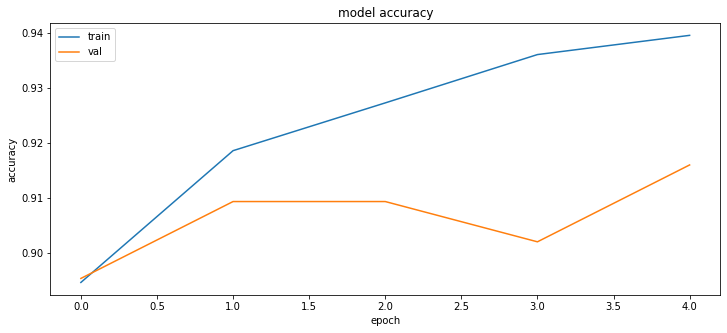

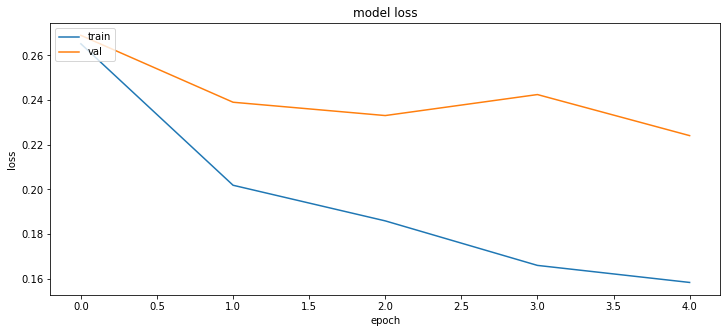

In [21]:
model_sentiment = tf.keras.models.load_model("models.h5")

import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12,5))
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
import tensorflow as tf 
model_sentiment = tf.keras.models.load_model("models.h5")

def predict(comment):
    comment = gensim.utils.simple_preprocess(comment)
    comment = ' '.join(comment)
    comment = ViTokenizer.tokenize(comment)
    # print(comment)
    maxtrix_embedding = np.expand_dims(comment_embedding(comment), axis=0)
    maxtrix_embedding = np.expand_dims(maxtrix_embedding, axis=3)
    result = model_sentiment.predict(maxtrix_embedding)
    # print(result)
    max_index = np.argmax(result)
    if max_index == 0: print("Tiêu cực")
    if max_index == 1: print("Tích cực")
    
    print(result[0][max_index]*100,"%")

In [42]:
predict("điện thoại mượt, pin tốt")

Tích cực
97.49811291694641 %


In [24]:
predict("mình rất thất vọng, lắp sim ko nhận")

Tiêu cực
94.22112107276917 %


In [25]:
predict("bắt wifi quá yếu") 

Tiêu cực
99.08246397972107 %


In [26]:
predict("không dùng được trả hàng")

Tiêu cực
84.95250344276428 %


In [27]:
predict("pin tệ quá")

Tiêu cực
99.17163252830505 %


In [28]:
predict("mua về ko dùng được, pin tệ, loa bé")

Tiêu cực
99.67401623725891 %


In [29]:
predict("mua về ko dùng được, pin tệ, loa bé")

Tiêu cực
99.67401623725891 %


In [30]:
predict("pin tệ, quá chán")

Tiêu cực
99.74256157875061 %


In [31]:
predict("pin tệ quá")

Tiêu cực
99.17163252830505 %


In [32]:
predict("không dùng được tôi muốn trả hàng")

Tiêu cực
93.62245798110962 %


In [33]:
predict("bắt wifi quá yếu") 

Tiêu cực
99.08246397972107 %


In [34]:
predict("mình rất thất vọng, lắp sim ko nhận")

Tiêu cực
94.22112107276917 %


In [35]:
predict("nhờ shop kích hoạt bảo hành")

Tích cực
86.62013411521912 %


In [36]:
predict("pin tệ quá yếu😁")

Tiêu cực
99.68090653419495 %


In [37]:
predict("pin tốt 😁")

Tích cực
94.0480649471283 %


In [38]:
print("Đánh giá PR")

test_result = model_sentiment.predict(x_train[12500:])
# print(test_result[:20])
# print(y_train[8000:8020])
#

Đánh giá PR


In [39]:
from sklearn.metrics import precision_score
y_predicts = test_result
# precision_score(y_true, y_pred, average='macro')

y_pred = []
for y_predict in y_predicts:
    max_index = np.argmax(y_predict)
    y_pred.append(max_index)  
print(y_pred)



y_true = []
for y in y_train[12500:]:
    max_index = np.argmax(y)
    y_true.append(max_index)  
print(y_true)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [40]:
micro = precision_score(y_true, y_pred, average='micro')
macro = precision_score(y_true, y_pred, average='macro')

print(micro); print(macro)

0.9117647058823529
0.8519094766619519
